In [81]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-




import sys

from sys import path

path.append('/home/wfstdbadmin/project_WFST/WFST_editable_modules/DIFF_EditableModules/zrf')
path.append('/home/wfstdbadmin/project_WFST/WFST_editable_modules/DIFF_EditableModules/zrf/Mgformer-Filter')
path.append('/Users/astronomy_zrf/Desktop/工作文献2/机器学习/WFST光变曲线读取')
path.append('/Users/astronomy_zrf/Desktop/工作文献2/机器学习/WFST光变曲线读取/Selected_LC/SN_like_from_WFST')


FILTER_MAP_NAME = 'TDE_candidate1'  # 如果不希望之前 filter得到的 map被覆盖掉/抹除，则可以换个新名称

N_PROCESSOR = 30  # 使用的并行进程数，建议不要超过30个


import numpy as np

from scipy.optimize import curve_fit


from astropy.stats import biweight_location
from functools import partial
import george
from george import kernels
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
import warnings
from scipy.optimize import OptimizeWarning


warnings.simplefilter("error", OptimizeWarning)
warnings.filterwarnings("ignore")


def basic_photometrics_without_Limit(candidate_source):
        PHOTOMETRY_DETECTED_FLAG = False
        n_flux_g = 0;n_flux_r = 0
        
        #测光数值正值判断
        if 'photometries' in candidate_source:
            photometries = candidate_source['photometries']
            if ('r' in photometries and len(photometries['r']['mjd']) >= 1) and (
                    'g' in photometries and len(photometries['g']['mjd']) >= 1):
                # 这里要求g 或 r波段至少有4个数据点
                
                for s in range(len(photometries['r']['flux'])):
                    if photometries['r']['flux'][s]>0 and photometries['r']['snr'][s]>5:
                        n_flux_r+=1
                for j in range(len(photometries['g']['flux'])):
                    if photometries['g']['flux'][j]>0 and photometries['g']['snr'][j]>5:
                        n_flux_g+=1                
                
                if n_flux_g>=2 and n_flux_r>=2 and n_flux_g+n_flux_r>4:#因为函数的拟合参数有四个
                    
                
                    PHOTOMETRY_DETECTED_FLAG = True

        return PHOTOMETRY_DETECTED_FLAG



#机器学习辅助Filter
import Transformer_ML_Filter
#model,mean,std =  Transformer_ML_Filter.load_model('test_model_ZTF(扩展样本).pth')
model,mean,std =  Transformer_ML_Filter.load_model('final_model_ZTF.pth',model_type='interp_GP')
#注意，test_model_ZTF_ref1.pth可能拥有非常严重的过拟合风险，因为训练集和测试集都揉碎了混在一起，只有取样时间的不同，所以很有可能同一个源的不同时间被分在一起了
#print("model load success")

#model_early,mean_1,std_1 = Transformer_ML_Filter.load_model('test_model_ZTF_ref1.pth',model_type = 'early')


def ML_Cks(lc_g,lc_r,model,mean,std,model_type = 'interp_GP'):
    #model,mean,std =  Transformer_ML_Filter.load_model()
    if model_type == 'normal':
        final_data = Transformer_ML_Filter.load_data(lc_g, lc_r)
    elif model_type == 'interp':
        final_data = Transformer_ML_Filter.load_data_interp(lc_g, lc_r)
    elif model_type == 'interp_GP':
        final_data = Transformer_ML_Filter.load_data_interp(lc_g, lc_r,interp_type='GP')
    probabilities = Transformer_ML_Filter.model_eval(final_data, model, mean, std)
    
    return probabilities


def shape_dictdata(candidate_source,test_stage = 0):#正式放上去的时候记得把test stage换成0
        ref_jde =  basic_photometrics_without_Limit(candidate_source)#这几个判据在SOURCE filter中会放在前面几个函数之后执行，这里暂时用不到红移
        #这个Filter不再对参考图像或者红移做出限制，只针对光变曲线本身而言
        #新增：如果在一天之内的变化幅度超过10，该天的观测直接放弃掉
        if ref_jde == True or test_stage == 1:

            #关于是否河内源能不能从参考图像上面看出来，还有待商榷
            metadata = {
                        }
            #波段对应,u=0,g=1,r=2
            g_band_rawdata = candidate_source['photometries']['g']
            r_band_rawdata = candidate_source['photometries']['r']
            
            if "u" in candidate_source['photometries']:
                u_band_rawdata = candidate_source['photometries']['u']
            else:
                u_band_rawdata = {'mjd':[],'flux':[],'flux_err':[]}
                
            

            
            
            reshape_obvdata_g = {'time':[],'band' : [],'flux':[],'flux_err':[]}
            reshape_obvdata_r = {'time':[],'band' : [],'flux':[],'flux_err':[]}
            reshape_obvdata_u = {'time':[],'band' : [],'flux':[],'flux_err':[]}
            proj_data = {'time':[],'band' : [],'flux':[],'flux_err':[]}
            #添加数据这一步，时间出现第一次作差
            for i in range(len(g_band_rawdata['mjd'])):
                
                reshape_obvdata_g['time'].append(g_band_rawdata['mjd'][i])
                reshape_obvdata_g['flux'].append(g_band_rawdata['flux'][i])
                reshape_obvdata_g['flux_err'].append(g_band_rawdata['flux_err'][i])
                reshape_obvdata_g['band'].append('g')
                
                proj_data['time'].append(g_band_rawdata['mjd'][i])
                proj_data['flux'].append(g_band_rawdata['flux'][i])
                proj_data['flux_err'].append(g_band_rawdata['flux_err'][i])
                proj_data['band'].append('g')
            
            for i in range(len(r_band_rawdata['mjd'])):
                
                reshape_obvdata_r['time'].append(r_band_rawdata['mjd'][i])
                reshape_obvdata_r['flux'].append(r_band_rawdata['flux'][i])
                reshape_obvdata_r['flux_err'].append(r_band_rawdata['flux_err'][i]) 
                reshape_obvdata_r['band'].append('r')
                
                proj_data['time'].append(r_band_rawdata['mjd'][i])
                proj_data['flux'].append(r_band_rawdata['flux'][i])
                proj_data['flux_err'].append(r_band_rawdata['flux_err'][i]) 
                proj_data['band'].append('r')
            
            for i in range(len(u_band_rawdata['mjd'])):
                
                reshape_obvdata_u['time'].append(u_band_rawdata['mjd'][i])
                reshape_obvdata_u['flux'].append(u_band_rawdata['flux'][i])
                reshape_obvdata_u['flux_err'].append(u_band_rawdata['flux_err'][i])
                reshape_obvdata_u['band'].append('u')
                
                proj_data['time'].append(u_band_rawdata['mjd'][i])
                proj_data['flux'].append(u_band_rawdata['flux'][i])
                proj_data['flux_err'].append(u_band_rawdata['flux_err'][i])
                proj_data['band'].append('u')
  
            astro_obj_proj1data = {'g':reshape_obvdata_g,'r':reshape_obvdata_r,'u':reshape_obvdata_u,'meta_data':metadata}
            
            mjd_start_g = min(astro_obj_proj1data['g']['time'])
            mjd_start_r = min(astro_obj_proj1data['r']['time'])
            if len(astro_obj_proj1data['u']['time'])>0:
                mjd_start_u = min(astro_obj_proj1data['u']['time'])
            else:
                mjd_start_u = 99999
            mjd_start = min([mjd_start_g,mjd_start_r,mjd_start_u])
            
            for i in range(len(astro_obj_proj1data['g']['time'])):
                astro_obj_proj1data['g']['time'][i]-=mjd_start
            for i in range(len(astro_obj_proj1data['r']['time'])):
                astro_obj_proj1data['r']['time'][i]-=mjd_start
            for i in range(len(astro_obj_proj1data['u']['time'])):
                astro_obj_proj1data['u']['time'][i]-=mjd_start
            for i in range(len(proj_data['time'])):
                proj_data['time'][i]-=mjd_start        
            
            proj2_data = proj_data
            return astro_obj_proj1data,proj2_data





def sources_filter(candidate_source,test =0):
    
    if basic_photometrics_without_Limit(candidate_source):                                                              
                                                  
        processed_data = shape_dictdata(candidate_source)[0]
        def cut_day(candidate_source,cut_time):
            '''
            该函数主要用于测试
            '''
            time_g = processed_data['g']['time']
            flux_g = processed_data['g']['flux']
            err_g  = processed_data['g']['flux_err']
    
            time_r = processed_data['r']['time']
            flux_r = processed_data['r']['flux']
            err_r  = processed_data['r']['flux_err']
            
            #数据截断，只取alert开始之后前100天的数据
            
            tg1 = [];fg1 = [];eg1 = []
            tr1 = [];fr1 = [];er1 = []
    
            for i in range(len(time_g)):
                if time_g[i]-time_g[0]<=cut_time:
                    tg1.append(time_g[i]);fg1.append(flux_g[i]);eg1.append(err_g[i])
            
            for i in range(len(time_r)):
                if time_r[i]-time_r[0]<=cut_time:
                    tr1.append(time_r[i]);fr1.append(flux_r[i]);er1.append(err_r[i])
            
            time_g = tg1;flux_g = fg1;err_g = eg1
            time_r = tr1;flux_r = fr1;err_r = er1
            
            return time_g,flux_g,err_g,time_r,flux_r,err_r

        #cut day只会在测试的时候使用
        if candidate_source['objectID'] == 'ZTF19aakiwze':
            cut_time = 400
        elif candidate_source['objectID'] == 'ZTF19aarioci':
            cut_time = 100
        elif candidate_source['objectID'] == 'ZTF19abzrhgq':
            cut_time = 200
        elif candidate_source['objectID'] == 'ZTF20abfcszi':
            cut_time = 300
        elif candidate_source['objectID'] == 'ZTF22aaabovl':
            cut_time = 100
        elif candidate_source['objectID'] == 'ZTF22abegjtx':
            cut_time = 150
        elif candidate_source['objectID'] == 'ZTF18acnbpmd':
            cut_time = 250
        elif candidate_source['objectID'] == 'ZTF21abaxaqq':
            cut_time = 150
        elif candidate_source['objectID'] == 'ZTF21abcgnqn':
            cut_time = 150
        elif candidate_source['objectID'] == 'ZTF21abqhkjd':
            cut_time = 100
        elif candidate_source['objectID'] == 'ZTF21aanxhjv':
            cut_time = 300
        else:
            cut_time = 9999
        
        time_g,flux_g,err_g,time_r,flux_r,err_r = cut_day(candidate_source,cut_time)
        
        time_u = processed_data['u']['time'];flux_u = processed_data['u']['flux'];err_u = processed_data['u']['flux_err']

        min_tg = np.min(time_g);min_tr = np.min(time_r);min_t = min(min_tg,min_tr)
        max_tg = np.max(time_g);max_tr = np.max(time_r);max_t = max(max_tg,max_tr)
    
    
        time_g = np.array(time_g)
        flux_g = np.array(flux_g)
        err_g = np.array(err_g)
        
        time_r = np.array(time_r)
        flux_r = np.array(flux_r)
        err_r = np.array(err_r)

        lc_g = [time_g,flux_g]
        lc_r = [time_r,flux_r]
        lc_u = [time_u,flux_u]

        t0_g=lc_g[0]
        t0_r=lc_r[0]
        
        
        ML_prob = ML_Cks(lc_g, lc_r, model, mean, std,model_type='interp_GP')
        
         
        TDE_score = ML_prob.numpy()[0]
 
       
        
       
        #print("full_lc: ",candidate_source['objectID'],' TDE score = ',np.round(TDE_score[0],decimals=2))
            
        return True,ML_prob.numpy()[0]

        
    else:
      
        return False,np.zeros(6)
            



def multi_duration_test(path_LC, single_name, LC_typefile, trigger_time=np.inf):
    import numpy as np
    import rdlc_WFST
    import rdlc_ZTF
    import PLAsTICC_res
    import rdlf_WFST_json

    #duration_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
    duration_list = [np.inf]
    result_dict = {'source_name': single_name}

    # 加载数据（只做一次）
    if LC_typefile == 'WFST':
        database_test1 = rdlc_WFST.rd(path_LC+single_name)
        database_test1 = rdlc_WFST.mutband_lc(database_test1)
    if LC_typefile == 'ZTF':
        database_test1 = rdlc_ZTF.ZTF_json(path_LC + single_name)
        database_test1 = rdlc_ZTF.ZTF_2_WFST_flux(database_test1)

    elif LC_typefile == 'ZTF_lasair':
        database_test1 = rdlc_ZTF.ZTF_json_lasair(path_LC + single_name)
        database_test1 = rdlc_ZTF.ZTF_2_WFST_flux(database_test1)

    elif LC_typefile == 'ZTF_lasair_forcephot':
        database_test1 = rdlc_ZTF.ZTF_json_lasair(path_LC + single_name)
        database_test1 = rdlc_ZTF.ZTF_2_WFST_forcephot(database_test1)

    elif LC_typefile == 'PLAsTICC':
        database_test1 = PLAsTICC_res.rdlc_PLAsTICC(path_LC + single_name)
        database_test1 = PLAsTICC_res.PLAsTICC_2_WFST_flux(database_test1)

    elif LC_typefile == 'WFST_json_MLR':
        database_test1 = rdlf_WFST_json.rdlc_WFST_json(path_LC + single_name)

    else:
        raise ValueError(f"Unsupported LC_typefile: {LC_typefile}")

    # 确定 trigger_MJD
    g_mjd = database_test1['g']['MJD']
    r_mjd = database_test1['r']['MJD']
    if len(g_mjd) > 0 and len(r_mjd) > 0:
        trigger_MJD = min(np.min(g_mjd), np.min(r_mjd))
    elif len(g_mjd) == 0 and len(r_mjd) > 0:
        trigger_MJD = np.min(r_mjd)
    elif len(g_mjd) > 0 and len(r_mjd) == 0:
        trigger_MJD = np.min(g_mjd)
    else:
        trigger_MJD = 0

    # 对每个 duration 单独运行
    for dur in duration_list:
        filtered_data = filter_data_by_mjd(database_test1, trigger_MJD=trigger_MJD, duration=[dur])

        test_data = {
            'objectID': filtered_data['objectID'],
            'photometries': {
                'g': {
                    'flux': filtered_data['g']['psf_flux'],
                    'flux_err': filtered_data['g']['psf_flux_err'],
                    'mjd': filtered_data['g']['MJD'],
                    'snr': np.array(filtered_data['g']['psf_flux']) / np.array(filtered_data['g']['psf_flux_err'])
                },
                'u': {
                    'flux': filtered_data['u']['psf_flux'],
                    'flux_err': filtered_data['u']['psf_flux_err'],
                    'mjd': filtered_data['u']['MJD'],
                    'snr': [-4.351764292970515, -11.12209952781576]
                },
                'r': {
                    'flux': filtered_data['r']['psf_flux'],
                    'flux_err': filtered_data['r']['psf_flux_err'],
                    'mjd': filtered_data['r']['MJD'],
                    'snr': np.array(filtered_data['r']['psf_flux']) / np.array(filtered_data['r']['psf_flux_err'])
                }
            }
        }

        ss, score_list = sources_filter(test_data)

        # 存储结果
        result_dict[f'score_{int(dur) if dur != np.inf else "inf"}'] = score_list

    return ss,result_dict




    

def filter_data_by_mjd(data_dict, trigger_MJD, duration,sep = False):
    # 定义一个过滤后的字典
    filtered_data = {}
    
    # 保留原字典中的 objectID 信息
    filtered_data['objectID'] = data_dict['objectID']
    
    # 遍历每个波段 ('u', 'g', 'r', 'i', 'z')
    for band in ['u', 'g', 'r', 'i', 'z']:
        data = data_dict.get(band, {'MJD': [], 'psf_flux': [], 'psf_flux_err': []})
        
        mjd = data['MJD']
        flux = data['psf_flux']
        flux_err = data['psf_flux_err']
        
        # 过滤MJD范围
        valid_indices = [i for i, m in enumerate(mjd) if trigger_MJD <= m < trigger_MJD + duration]
        
        # 如果有有效数据，按索引过滤MJD、flux和flux_err
        if valid_indices:
            filtered_data[band] = {
                'MJD': [mjd[i] for i in valid_indices],
                'psf_flux': [flux[i] for i in valid_indices],
                'psf_flux_err': [flux_err[i] for i in valid_indices]
            }
        else:
            # 如果没有有效数据，为该波段生成空列表
            filtered_data[band] = {
                'MJD': [],
                'psf_flux': [],
                'psf_flux_err': []
            }
    
    if sep==True:
        
        filtered_data['angular_distance'] = data_dict['angular_distance']
    
    return filtered_data

def convert_ndarray(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.float32) or isinstance(obj, np.float64):
        return float(obj)
    if isinstance(obj, np.int32) or isinstance(obj, np.int64):
        return int(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")
    
def jud_result(a,type_LC):
    re = 0
    de = 0
    for i in range(len(a)):
        if a[i]==True:
            re+=1
        if a[i]==False:
            de+=1
    
    print(type_LC+"Filter result: ",re,'/',re+de)
    
            

def mut_check(path_LC, type_LC, output_json='result_summary.json'):
    from tqdm import tqdm  # 可选：用于进度条
    filenames = os.listdir(path_LC)
    res1 = []

    # 根据类型筛选文件
    if type_LC in ['WFST']:
        target_files = [file for file in filenames if file.endswith('.txt')]
    elif type_LC in ['ZTF', 'WFST_json_MLR', 'ZTF_lasair', 'ZTF_lasair_forcephot', 'PLAsTICC']:
        target_files = [file for file in filenames if file.endswith('.json')]
    else:
        raise ValueError(f"Unsupported type_LC: {type_LC}")

    result_list = []

    for single_name in tqdm(target_files, desc='Processing files'):
        try:
            ss,result_dict = multi_duration_test(path_LC, single_name, type_LC)
            result_list.append(result_dict)
            res1.append(ss)
        except Exception as e:
            print(f"[ERROR] Failed to process {single_name}: {e}")

    # 保存结果为 JSON 文件
    output_path = '/Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/'+output_json
    with open(output_path, 'w') as f:
        json.dump(result_list, f, indent=2,default=convert_ndarray)

    print(f"\nResults saved to: {output_path}")
    
    
    return res1,result_list

    
    
    
    
    return result_list

if __name__ == '__main__':
    
    
        
    import time
    t_start = time.time()
    
    #所有的路径都是本地路径，目前支持3种格式，WFST-txt，ZTF-json, ZTF Lasair json
    path_LC_WFST = '/Users/astronomy_zrf/Desktop/工作文献2/机器学习/WFST光变曲线读取/Selected_LC/SN_like_from_WFST/'
    path_LC_ZTF = '/Users/astronomy_zrf/Desktop/工作文献2/机器学习/WFST光变曲线读取/_ZTF_TDElc/'
    path_LC_WFST_TDE_candidate = '/Users/astronomy_zrf/Desktop/WFST_TDE_candidate/'
    path_LC_WFST_fake = '/Users/astronomy_zrf/Desktop/工作文献2/机器学习/WFST光变曲线读取/others_database/WFST_other/'
    path_testarea = '/Users/astronomy_zrf/Desktop/成功的filter/第四个filter/一维高斯拟合/N64T24219_20240823/'
    path_res = '/Users/astronomy_zrf/Desktop/工作相关/WFST_SN+TDE/'
    path_qita = '/Users/astronomy_zrf/Desktop/工作相关/ZTF_SN_total/'
    path_all = '/Users/astronomy_zrf/Desktop/工作相关/WFST_SN+TDE ALL/'
    path_single = '/Users/astronomy_zrf/Desktop/工作相关/WFST某个单列数据/'
    path_rising_WFST = '/Users/astronomy_zrf/Desktop/工作相关/上升段样本构建/截取完毕的上升段/'
    path_rising_ZTF = '/Users/astronomy_zrf/Desktop/工作相关/上升段样本构建/截取完整的上升段ZTF/'
    path_ZTF_fail = '/Users/astronomy_zrf/Desktop/工作相关/经过TNS认证是TDE但是我觉得很可疑的源/'
    path_tde = '/Users/astronomy_zrf/Desktop/WFST_TDE_candidate/'
    path_wfts_sn1a = '/Users/astronomy_zrf/Desktop/工作相关/WFST超新星验证集/SN Ia/'
    
    path_lasair_filter = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-nd/'
    path_zhengshi = '/Users/astronomy_zrf/Desktop/工作相关/ZTF数据筛选临时存放位置/'
    path_2024_new = '/Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/ZTF New TDE 2024/'
    
    path_ZTF1_catalog = '/Users/astronomy_zrf/Desktop/工作相关/ZTF_I_TDE/'
    path_ZTF2_catalog = '/Users/astronomy_zrf/Desktop/工作相关/追加ZTF catalog/'
    path_ZTF3_catalog = '/Users/astronomy_zrf/Desktop/工作相关/ 追加ZTF-catalog-2/'
    path_ZTF4_catalog = '/Users/astronomy_zrf/Desktop/工作相关/ZTF TDE 2025/'
    
    path_TDE_total_reduced_sep = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-TDE_角距离小于0.5/'
    path_fake = '/Users/astronomy_zrf/Desktop/工作相关/典型假源数据/'
    
    path_other_filter_3 = '/Users/astronomy_zrf/Desktop/其他Filter选出的部分源/'
    path_other_filter_4 = '/Users/astronomy_zrf/Desktop/其他Filter选出的部分源/Filter4/'
    
    path_fake_rise = '/Users/astronomy_zrf/Desktop/工作相关/疑似假的上升段/'
    
    path_former = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-path-DP/'
    
    path_19 = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-2025428-2/'
    
    path_PLAsTICC_train_data = '/Users/astronomy_zrf/Desktop/工作相关/PLAsTICC_test/PLAsTICC_test1/'
    
    path_PLAsTICC_train_data_TDE = '/Users/astronomy_zrf/Desktop/工作相关/PLAsTICC_test/PLAsTICC_test1_TDE/'
    
    path_ZTF_NOTTDE = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF-NotTDE/'
    path_ZTF_NOTTDE_1 = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/not-tde-2/'
    path_ZTF_NOTTDE_2 = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/not-tde-4/'
    path_SNIa = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIa/'
    path_change_to_have_rising = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-TDE有机会找出上升段的源/'
    
    path_random = '/Users/astronomy_zrf/Desktop/工作相关/ZTF-NotTDE_extend/'#这个路径就是想装什么就装什么
    
    
    path_WFST_json = '/Users/astronomy_zrf/Desktop/成功的filter/第四个filter/一维高斯拟合/test/这个Filter能够选出所有的待筛选TDE/试运行15-保留负值点与信噪比的原汁原味数据_副本/固定参数结果/best_filter_v1/color_lossen/test_file/'
    path_new = '/Users/astronomy_zrf/Desktop/工作相关/WFST log/log candi1/'
    path_new2 = '/Users/astronomy_zrf/Desktop/工作相关/ZTF TDE 2025/'
    
    
    bb1 = mut_check(path_ZTF1_catalog,'ZTF',output_json='result_summary_TDE1_full_lc.json')
    bb2 = mut_check(path_ZTF2_catalog,'ZTF',output_json='result_summary_TDE2_full_lc.json')
    bb3 = mut_check(path_ZTF3_catalog,'ZTF',output_json='result_summary_TDE3_full_lc.json')
    #bb4 = mut_check(path_ZTF4_catalog,'ZTF',output_json='result_summary_TDE4.json')
    ztf_lasair_ck = mut_check(path_ZTF_NOTTDE_2,'ZTF_lasair',output_json='result_summary_NOT_TDE_full_lc.json')     
   
    #jud_result(bb1,'ZTF')
    #jud_result(bb2,'ZTF')
    #jud_result(bb3,'ZTF')
    #jud_result(bb4,'ZTF')
    
    
   
    
    #jud_result(ztf_lasair_ck, 'ZTF')
    
    # ZTF_PLAsTICC_ck = mut_check(path_PLAsTICC_train_data_TDE,'PLAsTICC')
    # jud_result(ZTF_PLAsTICC_ck, 'ZTF')
    
    t_end = time.time()
    t_cost = t_end - t_start
    print("source check:",t_cost)
    
    
    
    
                                                   
                                                                              

Processing files: 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]



Results saved to: /Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_TDE1_full_lc.json


Processing files: 100%|██████████| 18/18 [00:07<00:00,  2.39it/s]



Results saved to: /Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_TDE2_full_lc.json


Processing files: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]



Results saved to: /Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_TDE3_full_lc.json


Processing files: 100%|██████████| 7363/7363 [58:52<00:00,  2.08it/s]  



Results saved to: /Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_NOT_TDE_full_lc.json
source check: 3557.8037960529327


In [76]:
import os
import shutil
from collections import defaultdict

def copy_files_to_target(source_dirs, target_dir):
    os.makedirs(target_dir, exist_ok=True)

    file_sources = defaultdict(list)
    all_copied_files = set()
    duplicate_files = {}
    folder_file_counts = {}  # 每个文件夹的文件数量

    total_valid_files = 0  # 所有原始文件总数（不去重）

    print(f"📁 Target directory: {target_dir}\n")

    for source_dir in source_dirs:
        if not os.path.exists(source_dir):
            print(f"❌ Source directory '{source_dir}' does not exist. Skipping.")
            continue

        files = [f for f in os.listdir(source_dir) 
         if os.path.isfile(os.path.join(source_dir, f)) and f != ".DS_Store"]

        total_files = len(files)
        total_valid_files += total_files
        folder_file_counts[source_dir] = total_files
        copied_count = 0

        for filename in files:
            src_path = os.path.join(source_dir, filename)
            dest_path = os.path.join(target_dir, filename)

            file_sources[filename].append(source_dir)

            if filename in all_copied_files:
                duplicate_files[filename] = file_sources[filename]
                continue

            try:
                shutil.copy2(src_path, dest_path)
                all_copied_files.add(filename)
                copied_count += 1
            except Exception as e:
                print(f"⚠️ Failed to copy {filename} from {source_dir}: {e}")

        print(f"[{source_dir}]")
        print(f"  Total files: {total_files}")
        print(f"  Successfully copied: {copied_count}\n")

    # ➕ 统计信息
    adjusted_total = total_valid_files + 50
    print(f"\n📊 Total original file count (before removing duplicates): {total_valid_files}")
    print(f"📈 Adjusted total for ratio calculation: {adjusted_total}\n")

    for folder, count in folder_file_counts.items():
        percent = count / adjusted_total * 100
        print(f"  {folder}: {count} files ({percent:.2f}% of adjusted total)")

    # 重复文件报告
    if duplicate_files:
        print("\n⚠️ Duplicate files found and skipped:")
        for filename, dirs in duplicate_files.items():
            print(f"  '{filename}' appeared in: {', '.join(dirs)}")
    else:
        print("\n✅ No duplicate files found.")

# 示例用法
source_dirs = [
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF AGN",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SLSN-I",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SLSN-II",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SN Iax",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SN Ic",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SN-Ibc",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIa 91bg-like",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIb",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIbn",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIIb",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIIn",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIIP",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF_SN_total/SN Ia",
    "/Users/astronomy_zrf/Desktop/工作相关/ZTF_SN_total/SN II"
]
target_dir = "/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/not-tde-4"

copy_files_to_target(source_dirs, target_dir)


📁 Target directory: /Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/not-tde-4

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF AGN]
  Total files: 69
  Successfully copied: 69

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SLSN-I]
  Total files: 129
  Successfully copied: 129

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SLSN-II]
  Total files: 77
  Successfully copied: 77

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SN Iax]
  Total files: 24
  Successfully copied: 24

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SN Ic]
  Total files: 181
  Successfully copied: 181

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SN-Ibc]
  Total files: 36
  Successfully copied: 36

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIa 91bg-like]
  Total files: 69
  Successfully copied: 69

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIb]
  Total files: 160
  Successfully copied: 160

[/Users/astronomy_zrf/Desktop/工作相关/ZTF-SN/ZTF SNIbn]
  Total files: 40
  Successfully copied: 40

[/Users/astronomy_zrf/Desktop

### json Recall/Precision Caculate

In [2]:
import json
import pandas as pd
import os

def json_to_dataframe_with_label(json_path, score_index=0, label=1):
    """
    将一个JSON文件转换为DataFrame，并加入指定的真实标签
    - json_path: JSON文件路径
    - score_index: 每个score列表中要提取的索引
    - label: 指定的真实标签（0或1）
    """
    data = []
    with open(json_path, 'r') as f:
        records = json.load(f)
        for record in records:
            # 原始 source_name 例如 "ZTF19acspeuw_difference_photometry.json"
            full_name = record['source_name']
            # 保留 "ZTF19acspeuw"
            short_name = full_name.split('_')[0]

            row = {'source_name': short_name}
            for key, value in record.items():
                if key.startswith('score_'):
                    try:
                        row[key] = value[score_index]
                    except IndexError:
                        row[key] = None
            row['label'] = label
            data.append(row)

    return pd.DataFrame(data)



df_TDE1 = json_to_dataframe_with_label('/Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_TDE1.json', score_index=0, label=0)
df_TDE2 = json_to_dataframe_with_label('/Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_TDE2.json', score_index=0, label=0)
df_TDE3 = json_to_dataframe_with_label('/Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_TDE3.json', score_index=0, label=0)
df_NOTTDE = json_to_dataframe_with_label('/Users/astronomy_zrf/Desktop/工作相关/MgFormer/Mgformer-Filter/mut_Result/result_summary_NOT_TDE_2.json', score_index=0, label=1)
display(df_NOTTDE)

,source_name,score_10,score_20,score_30,score_40,score_50,score_60,score_70,score_80,score_90,score_100,score_inf,label
0,ZTF22aaparwk,0.000225,0.042383,0.004856,0.005926,0.000075,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,1
1,ZTF21abvgouw,0.005582,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,1
2,ZTF23abtniaf,0.000000,0.000000,0.000000,0.000014,0.000014,0.000014,0.000006,0.000004,0.000003,0.000003,0.000008,1
3,ZTF22abfvzqg,0.000046,0.000013,0.000014,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,1
4,ZTF21aciqppd,0.000000,0.000007,0.000018,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,ZTF22aabfuju,0.000000,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,1
7359,ZTF22aaftcmp,0.000048,0.000024,0.000008,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,1
7360,ZTF20abgpksj,0.000011,0.000006,0.000008,0.000003,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,1
7361,ZTF23abgfwhj,0.000000,0.000004,0.000005,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,1


[0.045454545454545456, 0.25, 0.2840909090909091, 0.41836734693877553, 0.4090909090909091, 0.375, 0.3409090909090909, 0.3458646616541353, 0.3404255319148936, 0.3333333333333333, 0.3333333333333333]
[0, 0.5714285714285714, 0.6956521739130435, 0.7297297297297297, 0.7142857142857143, 0.7708333333333334, 0.75, 0.7346938775510204, 0.7254901960784313, 0.78, 0.7692307692307693]
[0, 0, 0.7333333333333333, 0.8076923076923077, 0.7666666666666667, 0.7777777777777778, 0.8421052631578947, 0.8461538461538461, 0.8048780487804879, 0.8571428571428571, 0.8372093023255814]


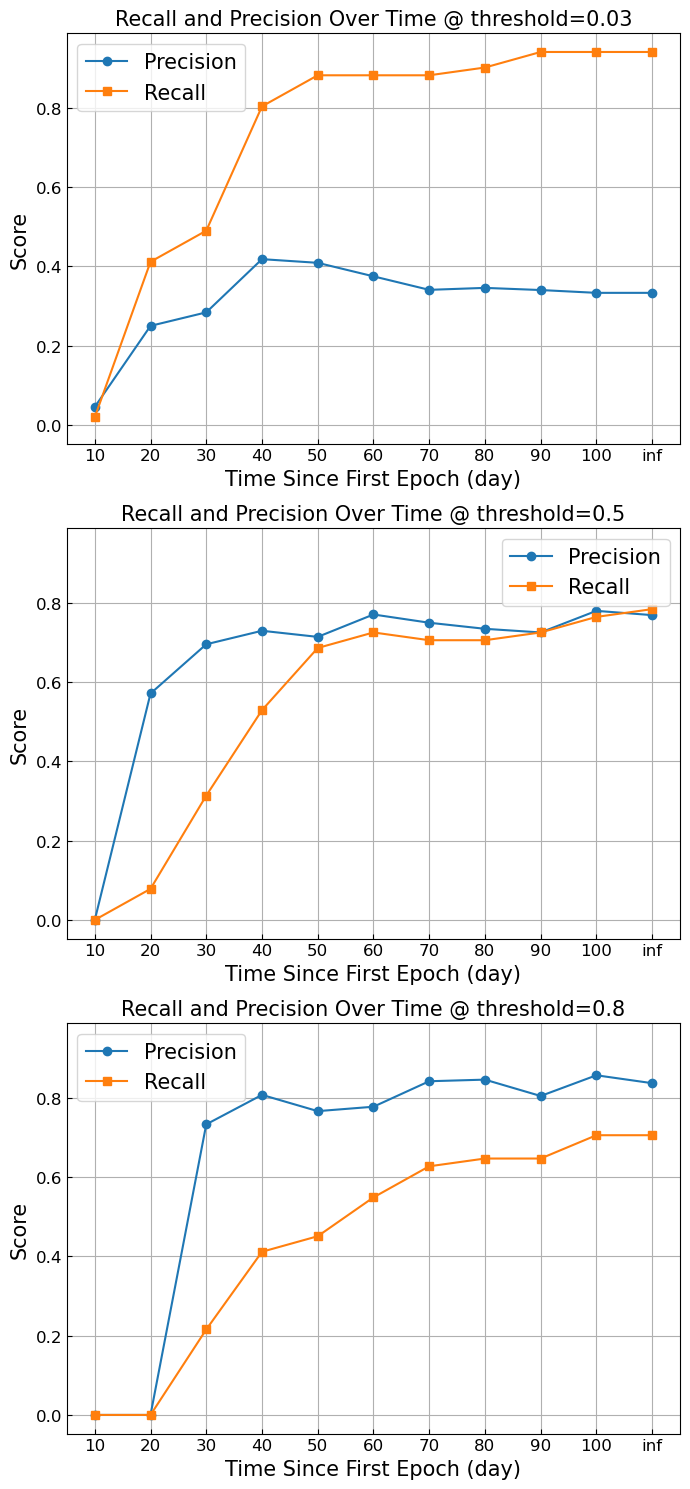

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import math

def plot_precision_recall_across_durations(dataframes, labels, threshold=0.5, focus_label=1):
    """
    dataframes: List[pd.DataFrame]，每个DataFrame含有 source_name, score_xx, label列
    labels: List[int]，每个DataFrame对应的真实标签
    threshold: float or List[float]，大于该阈值即为预测为正类（可传多个）
    focus_label: int，仅对该真实标签计算 PR
    """
    assert len(dataframes) == len(labels), "每个DataFrame必须有一个对应的真实标签"

    if not isinstance(threshold, list):
        threshold = [threshold]

    score_keys = [f"score_{i}" for i in list(range(10, 101, 10)) + ["inf"]]

    # 合并并更新标签
    all_df = []
    for df, label in zip(dataframes, labels):
        df = df.copy()
        df['label'] = label
        all_df.append(df)
    merged_df = pd.concat(all_df, ignore_index=True)

    # 设置子图行列数
    num_thresholds = len(threshold)
    cols = 1
    rows = math.ceil(num_thresholds / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, th in enumerate(threshold):
        precision_list = []
        recall_list = []
        durations = []

        for key in score_keys:
            if key not in merged_df.columns:
                continue

            prob = merged_df[key]
            true = merged_df['label'] == focus_label
            pred = prob > th

            precision = precision_score(true, pred) if pred.sum() > 0 else 0
            recall = recall_score(true, pred) if true.sum() > 0 else 0

            precision_list.append(precision)
            recall_list.append(recall)
            durations.append(key.replace('score_', ''))
        print(precision_list)
        ax = axes[idx]
        ax.plot(durations, precision_list, marker='o', label='Precision')
        ax.plot(durations, recall_list, marker='s', label='Recall')
        ax.set_title(f'Recall and Precision Over Time @ threshold={th}', fontsize=15)
        ax.set_xlabel('Time Since First Epoch (day)', fontsize=15)
        ax.set_ylabel('Score', fontsize=15)
        ax.tick_params(axis='x', labelsize=12,labelbottom=True)
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(direction='in')
        ax.grid(True)
        ax.legend(fontsize=15)

    # 删除多余的子图
    for j in range(len(threshold), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('Precision_and_Recall_All_Thresholds_Subplots.png')
    plt.show()

dfs = [df_TDE1, df_TDE2, df_TDE3,df_NOTTDE]
true_labels = [0, 0, 0,1]

plot_precision_recall_across_durations(dfs, true_labels, threshold=[0.03,0.5,0.8], focus_label=0)

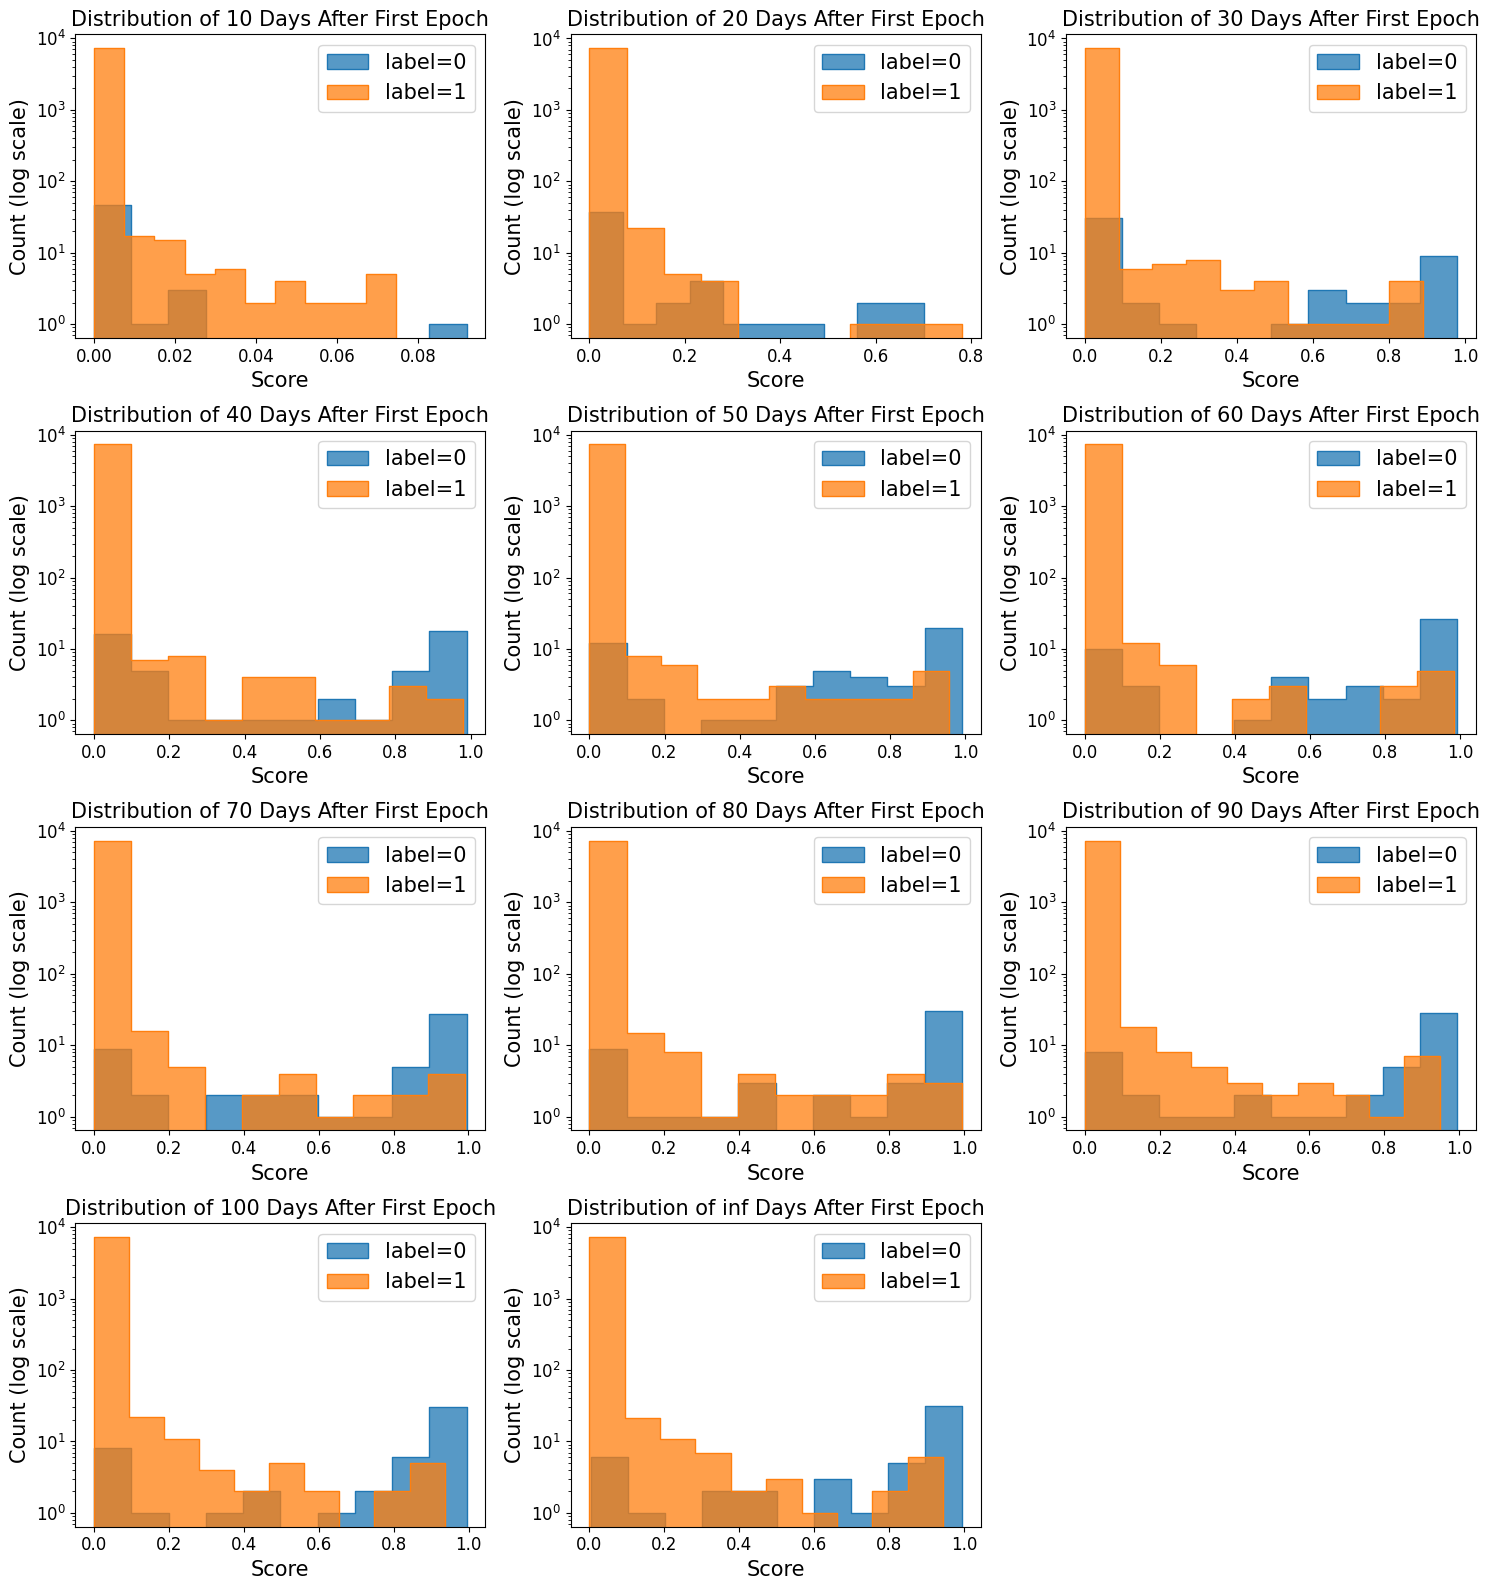

In [80]:
import seaborn as sns
import pandas as pd

def plot_score_distributions(dataframes, labels, score_keys=None, max_cols=3, bins=10):
    """
    绘制多个 DataFrame 中不同 label 的 score 分布直方图，纵轴为 log scale。
    
    参数：
    - dataframes: List[pd.DataFrame]
    - labels: List[int]
    - score_keys: List[str] or None
    - max_cols: int - 每行子图数
    - bins: int - 直方图 bin 数
    """
    assert len(dataframes) == len(labels), "DataFrame 和 标签数量不一致"
    
    # 合并数据并附上 label
    all_df = []
    for df, label in zip(dataframes, labels):
        df = df.copy()
        df['label'] = label
        all_df.append(df)
    merged_df = pd.concat(all_df, ignore_index=True)

    if score_keys is None:
        score_keys = [col for col in merged_df.columns if col.startswith("score_")]

    n_plots = len(score_keys)
    n_rows = (n_plots + max_cols - 1) // max_cols
    plt.figure(figsize=(max_cols * 5, n_rows * 4))

    for idx, key in enumerate(score_keys):
        plt.subplot(n_rows, max_cols, idx + 1)
        for label_val in sorted(merged_df['label'].unique()):
            data = merged_df[merged_df['label'] == label_val][key]
            # 避免出现负值或NaN
            data = data.replace([np.inf, -np.inf], np.nan).dropna()
            if not data.empty:
                sns.histplot(
                    data,
                    bins=bins,
                    kde=False,
                    stat='count',
                    label=f'label={label_val}',
                    element='step'
                )
        day_dur = key.split('_')[-1]
        plt.yscale("log")
        plt.title(f'Distribution of {day_dur} Days After First Epoch',fontsize=15)
        plt.xlabel('Score',fontsize=15)
        plt.ylabel('Count (log scale)',fontsize=15)
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
        plt.legend(fontsize=15)

    plt.tight_layout()
    plt.savefig('score_distribution.png')
    plt.show()

dfs = [df_TDE1, df_TDE2, df_TDE3,df_NOTTDE]
true_labels = [0, 0, 0,1]

plot_score_distributions(dfs, true_labels)

## Time evolution

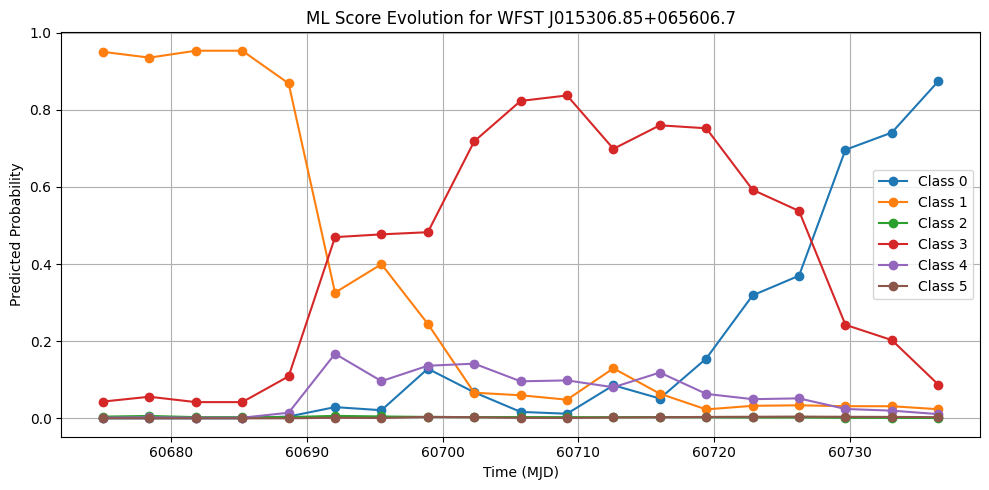

In [125]:
import numpy as np
import matplotlib.pyplot as plt



def ML_prob_evolution_plot(path_LC, single_name, LC_typefile, model, mean, std, model_type='interp_GP', 
                           class_index=0, time_grid=None):

    import numpy as np
    import matplotlib.pyplot as plt
    import rdlc_WFST
    import rdlc_ZTF
    import PLAsTICC_res
    import rdlf_WFST_json

    # 确保 class_index 是 list
    if isinstance(class_index, int):
        class_index = [class_index]

    # 加载数据
    if LC_typefile == 'WFST':
        database_test1 = rdlc_WFST.rd(path_LC + single_name)
        database_test1 = rdlc_WFST.mutband_lc(database_test1)
    elif LC_typefile == 'ZTF':
        database_test1 = rdlc_ZTF.ZTF_json(path_LC + single_name)
        database_test1 = rdlc_ZTF.ZTF_2_WFST_flux(database_test1)
    elif LC_typefile == 'ZTF_lasair':
        database_test1 = rdlc_ZTF.ZTF_json_lasair(path_LC + single_name)
        database_test1 = rdlc_ZTF.ZTF_2_WFST_flux(database_test1)
    elif LC_typefile == 'ZTF_lasair_forcephot':
        database_test1 = rdlc_ZTF.ZTF_json_lasair(path_LC + single_name)
        database_test1 = rdlc_ZTF.ZTF_2_WFST_forcephot(database_test1)
    elif LC_typefile == 'PLAsTICC':
        database_test1 = PLAsTICC_res.rdlc_PLAsTICC(path_LC + single_name)
        database_test1 = PLAsTICC_res.PLAsTICC_2_WFST_flux(database_test1)
    elif LC_typefile == 'WFST_json_MLR':
        database_test1 = rdlf_WFST_json.rdlc_WFST_json(path_LC + single_name)
    else:
        raise ValueError(f"Unsupported LC_typefile: {LC_typefile}")

    # 获取时间和 flux
    g_time = np.array(database_test1['g']['MJD'])
    g_flux = np.array(database_test1['g']['psf_flux'])
    r_time = np.array(database_test1['r']['MJD'])
    r_flux = np.array(database_test1['r']['psf_flux'])

    # 构造时间网格
    if time_grid is None:
        all_times = np.concatenate([g_time, r_time])
        time_min = np.min(all_times)
        time_max = np.max(all_times)
        time_grid = np.linspace(time_min, time_max, 20)

    # 初始化每个分类的概率数组
    class_probs = {i: [] for i in class_index}

    for t in time_grid:
        mask_g = g_time < t
        mask_r = r_time < t

        if np.sum(mask_g) == 0 or np.sum(mask_r) == 0:
            for i in class_index:
                class_probs[i].append(np.nan)
            continue

        lc_g = [g_time[mask_g], g_flux[mask_g]]
        lc_r = [r_time[mask_r], r_flux[mask_r]]

        try:
            prob = ML_Cks(lc_g, lc_r, model, mean, std, model_type=model_type)
            if hasattr(prob, 'squeeze'):
                prob = prob.squeeze()
            for i in class_index:
                if i < len(prob):
                    class_probs[i].append(prob[i].item())
                else:
                    class_probs[i].append(np.nan)
        except Exception as e:
            print(f"ML_Cks failed at time {t}: {e}")
            for i in class_index:
                class_probs[i].append(np.nan)

    # 解析目标名
    single_name_clean = single_name.split("_")[-1].replace(".txt", "")

    # 绘图
    plt.figure(figsize=(10, 5))
    for i in class_index:
        plt.plot(time_grid, class_probs[i], marker='o', linestyle='-', label=f'Class {i}')
    
    plt.xlabel("Time (MJD)")
    plt.ylabel("Predicted Probability")
    plt.title(f"ML Score Evolution for {single_name_clean}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return time_grid, class_probs

#机器学习辅助Filter
import Transformer_ML_Filter
#model,mean,std =  Transformer_ML_Filter.load_model('test_model_ZTF(扩展样本).pth')
model,mean,std =  Transformer_ML_Filter.load_model('final_model_ZTF.pth',model_type='interp_GP')

time_grid, probs = ML_prob_evolution_plot(
    path_LC='/Users/astronomy_zrf/Desktop/工作相关/最后实验/TDE分数校准/', 
    single_name='WFST_LC_6597847155736865_WFST J015306.85+065606.7.txt', 
    LC_typefile='WFST', 
    model=model, 
    mean=mean, 
    std=std, 
    model_type='interp_GP', 
    class_index=[0,1,2,3,4,5],
    
)


In [101]:

import re
from textwrap import wrap

# 原始字符串（示例，实际应为完整字符串）
input_text = r"""
\texttt{ZTF18abxftqm — 0.9736} & \texttt{ZTF19aakswrb — 0.9323} & \texttt{ZTF22aaabovl — 0.9482} \\
\texttt{ZTF18acaqdaa — 0.9782} & \texttt{ZTF19aaniqrr — 0.9833} & \texttt{ZTF22aaaedas — 0.9503} \\
\texttt{ZTF18acnbpmd — 0.9941} & \texttt{ZTF20abgwfek — 0.4769} & \texttt{ZTF22aaahtqz — 0.9201} \\
\texttt{ZTF19aabbnzo — 0.9903} & \texttt{ZTF20achpcvt — 0.9741} & \texttt{ZTF22aacgcwv — 0.0700} \\
\texttt{ZTF19aakiwze — 0.9433} & \texttt{ZTF20acnznms — 0.8265} & \texttt{ZTF22aadesap — 0.0787} \\
\texttt{ZTF19aapreis — 0.9893} & \texttt{ZTF20acwytxn — 0.9512} & \texttt{ZTF22aavvqyh — 0.3056} \\
\texttt{ZTF19aarioci — 0.7062} & \texttt{ZTF21aaaokyp — 0.6749} & \texttt{ZTF22abajudi — 0.9419} \\
\texttt{ZTF19abhhjcc — 0.9344} & \texttt{ZTF21aakfqwq — 0.8968} & \texttt{ZTF22abegjtx — 0.3682} \\
\texttt{ZTF19abidbya — 0.1680} & \texttt{ZTF21aanxhjv — 0.8643} & \texttt{ZTF22abkfhua — 0.9638} \\
\texttt{ZTF19abzrhgq — 0.0101} & \texttt{ZTF21abaxaqq — 0.6000} & \texttt{ZTF23aadcbay — 0.4717} \\
\texttt{ZTF19accmaxo — 0.9855} & \texttt{ZTF21abcgnqn — 0.7749} & \texttt{ZTF23abcvbqq — 0.9733} \\
\texttt{ZTF19acspeuw — 0.8991} & \texttt{ZTF21abhrchb — 0.0720} & \texttt{ZTF24abmybnp — 0.6760} \\
\texttt{ZTF20aabqihu — 0.8410} & \texttt{ZTF21abjrysr — 0.6255} & \texttt{ZTF22aagvrlq — 0.8859} \\
\texttt{ZTF20aamqmfk — 0.9944} & \texttt{ZTF21abqhkjd — 0.9129} & \nodata \\
\texttt{ZTF20abefeab — 0.9875} & \texttt{ZTF21abxngcz — 0.9949} & \nodata \\
\texttt{ZTF20abfcszi — 0.8230} & \texttt{ZTF21acafvhf — 0.9777} & \nodata \\
\texttt{ZTF20abjwvae — 0.9925} & \nodata & \nodata \\
\texttt{ZTF20abnorit — 0.9829} & \nodata & \nodata \\
\texttt{ZTF20abowque — 0.9901} & \nodata & \nodata \\
\texttt{ZTF20acitpfz — 0.0206} & \nodata & \nodata \\
\texttt{ZTF20acqoiyt — 0.9453} & \nodata & \nodata \\
"""

# Parse into rows and columns
rows = input_text.strip().split("\\\\\n")
table = []

for row in rows:
    cols = []
    for cell in row.split(" & "):
        match = re.match(r"\\texttt\{([^}]+)\}", cell)
        if match:
            cols.append(match.group(1))
        elif r"\nodata" in cell:
            cols.append("\nodata")
        else:
            cols.append("")
    table.append(cols)

# Convert to numpy array for easy column-wise processing
array = np.array(table, dtype=object)

# Sort each column individually while keeping \nodata in original positions
sorted_array = array.copy()
for col_idx in range(array.shape[1]):
    col = array[:, col_idx]
    data_with_indices = [(i, v) for i, v in enumerate(col) if v != "\nodata"]
    sorted_values = sorted([v for _, v in data_with_indices])
    for (i, _), v in zip(data_with_indices, sorted_values):
        sorted_array[i, col_idx] = v

# Format back to LaTeX-style string
output_lines = []
for row in sorted_array:
    formatted_row = " & ".join(
        f"\\texttt{{{cell}}}" if cell != "\nodata" else "\\nodata" for cell in row
    )
    output_lines.append(formatted_row + r" \\")

final_output = "\n".join(output_lines)
final_output[:1000]  # Preview the beginning of output
print(final_output)

\texttt{ZTF18abxftqm — 0.9736} & \texttt{ZTF19aakswrb — 0.9323} & \texttt{ZTF22aaabovl — 0.9482} \\
\texttt{ZTF18acaqdaa — 0.9782} & \texttt{ZTF19aaniqrr — 0.9833} & \texttt{ZTF22aaaedas — 0.9503} \\
\texttt{ZTF18acnbpmd — 0.9941} & \texttt{ZTF20abgwfek — 0.4769} & \texttt{ZTF22aaahtqz — 0.9201} \\
\texttt{ZTF19aabbnzo — 0.9903} & \texttt{ZTF20achpcvt — 0.9741} & \texttt{ZTF22aacgcwv — 0.0700} \\
\texttt{ZTF19aakiwze — 0.9433} & \texttt{ZTF20acnznms — 0.8265} & \texttt{ZTF22aadesap — 0.0787} \\
\texttt{ZTF19aapreis — 0.9893} & \texttt{ZTF20acwytxn — 0.9512} & \texttt{ZTF22aagvrlq — 0.8859} \\
\texttt{ZTF19aarioci — 0.7062} & \texttt{ZTF21aaaokyp — 0.6749} & \texttt{ZTF22aavvqyh — 0.3056} \\
\texttt{ZTF19abhhjcc — 0.9344} & \texttt{ZTF21aakfqwq — 0.8968} & \texttt{ZTF22abajudi — 0.9419} \\
\texttt{ZTF19abidbya — 0.1680} & \texttt{ZTF21aanxhjv — 0.8643} & \texttt{ZTF22abegjtx — 0.3682} \\
\texttt{ZTF19abzrhgq — 0.0101} & \texttt{ZTF21abaxaqq — 0.6000} & \texttt{ZTF22abkfhua — 0.9638} \\


In [102]:
import re

# 源字符串：包含新的 TDE 分数
source_text = """
full_lc:  ZTF19acspeuw  TDE score =  0.8991
full_lc:  ZTF19aapreis  TDE score =  0.9893
full_lc:  ZTF19aarioci  TDE score =  0.7062
full_lc:  ZTF19aabbnzo  TDE score =  0.9903
full_lc:  ZTF20abfcszi  TDE score =  0.823
full_lc:  ZTF19aakiwze  TDE score =  0.9433
full_lc:  ZTF18acnbpmd  TDE score =  0.9941
full_lc:  ZTF20abefeab  TDE score =  0.9875
full_lc:  ZTF20aamqmfk  TDE score =  0.9944
full_lc:  ZTF18abxftqm  TDE score =  0.9736
full_lc:  ZTF19abhhjcc  TDE score =  0.9344
full_lc:  ZTF20abowque  TDE score =  0.9901
full_lc:  ZTF20acitpfz  TDE score =  0.0206
full_lc:  ZTF20aabqihu  TDE score =  0.841
full_lc:  ZTF20abjwvae  TDE score =  0.9925
full_lc:  ZTF20abnorit  TDE score =  0.9829
full_lc:  ZTF19abzrhgq  TDE score =  0.0101
full_lc:  ZTF20acqoiyt  TDE score =  0.9453
full_lc:  ZTF19accmaxo  TDE score =  0.9855
full_lc:  ZTF19abidbya  TDE score =  0.168
full_lc:  ZTF18acaqdaa  TDE score =  0.9782
full_lc:  ZTF22aagvrlq  TDE score =  0.8859
full_lc:  ZTF20acnznms  TDE score =  0.8265
full_lc:  ZTF21aaaokyp  TDE score =  0.6749
full_lc:  ZTF21aanxhjv  TDE score =  0.8643
full_lc:  ZTF21aakfqwq  TDE score =  0.8968
full_lc:  ZTF18acnbpmd  TDE score =  0.9941
full_lc:  ZTF19aaniqrr  TDE score =  0.9833
full_lc:  ZTF20achpcvt  TDE score =  0.9741
full_lc:  ZTF20acwytxn  TDE score =  0.9512
full_lc:  ZTF21abaxaqq  TDE score =  0.6
full_lc:  ZTF21abxngcz  TDE score =  0.9949
full_lc:  ZTF19aakswrb  TDE score =  0.9323
full_lc:  ZTF21abcgnqn  TDE score =  0.7749
full_lc:  ZTF20abgwfek  TDE score =  0.4769
full_lc:  ZTF21abhrchb  TDE score =  0.072
full_lc:  ZTF21abjrysr  TDE score =  0.6255
full_lc:  ZTF21acafvhf  TDE score =  0.9777
full_lc:  ZTF21abqhkjd  TDE score =  0.9129
full_lc:  ZTF23aadcbay  TDE score =  0.4717
full_lc:  ZTF22aavvqyh  TDE score =  0.3056
full_lc:  ZTF22abegjtx  TDE score =  0.3682
full_lc:  ZTF22aaabovl  TDE score =  0.9482
full_lc:  ZTF23abcvbqq  TDE score =  0.9733
full_lc:  ZTF22abkfhua  TDE score =  0.9638
full_lc:  ZTF21abxngcz  TDE score =  0.9949
full_lc:  ZTF22aacgcwv  TDE score =  0.07
full_lc:  ZTF22aaaedas  TDE score =  0.9503
full_lc:  ZTF22aadesap  TDE score =  0.0787
full_lc:  ZTF22aaahtqz  TDE score =  0.9201
full_lc:  ZTF22abajudi  TDE score =  0.9419
"""

# 需要替换的目标字符串
target_text = final_output


# Step 2: 在 target_text 中替换旧分数为新分数
# 修复正则提取：使用分组同时提取 object_id 和 score
score_tuples = re.findall(r'full_lc:\s+(ZTF\d+[a-z]+)\s+TDE score =\s+([\d.]+)', source_text)
score_map = dict(score_tuples)

# 替换目标字符串中的对应 score
def replace_score(match):
    obj_id = match.group(1)
    if obj_id in score_map:
        new_score = score_map[obj_id]
        return f"\\texttt{{{obj_id} — {new_score}}}"
    return match.group(0)

updated_text = re.sub(r'\\texttt\{(ZTF\d+[a-z]+) — [\d.]+\}', replace_score, target_text)
#updated_text.strip()[:1000]  # 显示前1000字符确认效果
print(updated_text)

\texttt{ZTF18abxftqm — 0.9736} & \texttt{ZTF19aakswrb — 0.9323} & \texttt{ZTF22aaabovl — 0.9482} \\
\texttt{ZTF18acaqdaa — 0.9782} & \texttt{ZTF19aaniqrr — 0.9833} & \texttt{ZTF22aaaedas — 0.9503} \\
\texttt{ZTF18acnbpmd — 0.9941} & \texttt{ZTF20abgwfek — 0.4769} & \texttt{ZTF22aaahtqz — 0.9201} \\
\texttt{ZTF19aabbnzo — 0.9903} & \texttt{ZTF20achpcvt — 0.9741} & \texttt{ZTF22aacgcwv — 0.07} \\
\texttt{ZTF19aakiwze — 0.9433} & \texttt{ZTF20acnznms — 0.8265} & \texttt{ZTF22aadesap — 0.0787} \\
\texttt{ZTF19aapreis — 0.9893} & \texttt{ZTF20acwytxn — 0.9512} & \texttt{ZTF22aagvrlq — 0.8859} \\
\texttt{ZTF19aarioci — 0.7062} & \texttt{ZTF21aaaokyp — 0.6749} & \texttt{ZTF22aavvqyh — 0.3056} \\
\texttt{ZTF19abhhjcc — 0.9344} & \texttt{ZTF21aakfqwq — 0.8968} & \texttt{ZTF22abajudi — 0.9419} \\
\texttt{ZTF19abidbya — 0.168} & \texttt{ZTF21aanxhjv — 0.8643} & \texttt{ZTF22abegjtx — 0.3682} \\
\texttt{ZTF19abzrhgq — 0.0101} & \texttt{ZTF21abaxaqq — 0.6} & \texttt{ZTF22abkfhua — 0.9638} \\
\textt

In [108]:
input_text = """WFST0592wbwf & SN 2025jus & SN Ia & SN Ia & [0.00 \textbf{0.90} 0.02 0.08 0.00 0.00] \\\\
WFST0576afqj & SN 2025hma & SN Ia & SN Ia & [0.00 \textbf{0.98} 0.00 0.01 0.00 0.00] \\\\
WFST0576btxl & SN 2025gvy & SN Ia & SN Ia & [0.00 \textbf{0.78} 0.07 0.15 0.00 0.00] \\\\
WFST0547cguo & SN 2025ezb & SN Ia & SN Ia & [0.00 \textbf{0.99} 0.00 0.00 0.00 0.00] \\\\
WFST0548prfg & SN 2025ewp & SN II & SN II & [0.00 0.02 0.00 \textbf{0.87} 0.10 0.00] \\\\
WFST0538yiwh & SN 2025eui & SN Ia & SN Ia & [0.00 \textbf{0.95} 0.01 0.04 0.00 0.00] \\\\
WFST0532rzok & SN 2025dke & SN IIn & SN II & [0.00 0.01 0.01 \textbf{0.65} 0.33 0.00] \\\\
WFST0521jnjd & SN 2025dht & SN IIn & SN II & [0.01 0.11 0.02 \textbf{0.78} 0.08 0.00] \\\\
WFST0524aarnv & SN 2025dbu & SN Ia & SN Ia & [0.00 \textbf{1.00} 0.00 0.00 0.00 0.00] \\\\
WFST0521jxvt & SN 2025cdj & SN Ia & SN II & [0.00 0.01 0.00 \textbf{0.84} 0.14 0.00] \\\\
WFST0509jgnf & SN 2025bzq & SN Ia & SN Ia & [0.00 \textbf{0.99} 0.00 0.00 0.00 0.00] \\\\
WFST0524fjjv & SN 2025bvg & SN Ia & SN Ia & [0.00 \textbf{0.94} 0.02 0.03 0.00 0.00] \\\\
WFST0496dkhg & SN 2025ble & SN Ia & SN Ia & [0.00 \textbf{0.99} 0.00 0.00 0.00 0.00] \\\\
WFST0509bawa & SN 2025bco & SN II & SN II & [0.00 0.01 0.00 \textbf{0.92} 0.07 0.00] \\\\
WFST0509gpyj & SN 2025ayo & SN Ia & SN Ia & [0.00 \textbf{0.97} 0.02 0.02 0.00 0.00] \\\\
WFST0509ibul & SN 2025apn & SN Ic & SN Ib/c & [0.00 0.01 \textbf{0.51} 0.47 0.00 0.00] \\\\
WFST0520dxql & SN 2025akj & SN Ia & SN Ia & [0.00 \textbf{0.60} 0.17 0.22 0.00 0.00] \\\\
WFST0521ezja & SN 2025acu & SN Ia & SN Ia & [0.00 \textbf{0.91} 0.03 0.06 0.00 0.00] \\\\
WFST0510xkc & SN 2025acj & SN Ia & SN Ia & [0.00 \textbf{0.87} 0.05 0.07 0.00 0.00] \\\\
WFST0509gxhh & SN 2025lq & SN II & SN II & [0.00 0.00 0.03 \textbf{0.96} 0.01 0.00] \\\\
WFST0454gagb & SN 2024aedt & SN Ia & SN Ia & [0.00 \textbf{0.87} 0.06 0.07 0.00 0.00] \\\\
WFST-PS240703a & SN 2024ozs & SN Ia & SN Ia & [0.00 \textbf{0.94} 0.03 0.03 0.00 0.00] \\\\
WFST-PS240504x & SN 2024kxr & SN Ia & SN Ia & [0.00 \textbf{0.99} 0.00 0.01 0.00 0.00] \\\\
WFST-PS240530q & SN 2024kbd & SN Ia & SN Ia & [0.00 \textbf{0.99} 0.00 0.00 0.00 0.00] \\\\
WFST-PS240520a & SN 2024jyc & SN Ia & SN Ia & [0.00 \textbf{0.82} 0.04 0.13 0.00 0.00] \\\\
WFST-PS240530am & SN 2024jvn & SN Ia & SN Ia & [0.00 \textbf{1.00} 0.00 0.00 0.00 0.00] \\\\
WFST-PS240513c & SN 2024jbb & SN Ia & SN Ia & [0.00 \textbf{0.96} 0.01 0.03 0.00 0.00] \\\\
WFST-PS240410a & SN 2024hqr & SN Ia & SN Ib/c & [0.00 0.07 \textbf{0.72} 0.21 0.00 0.00] \\\\
WFST-PS240407h & SN 2024gmn & SN Ia & SN Ia & [0.00 \textbf{0.78} 0.02 0.19 0.01 0.00] \\\\
WFST-PS240410d & SN 2024gme & SN Ia & SN Ia & [0.00 \textbf{1.00} 0.00 0.00 0.00 0.00] \\\\
WFST-PS240328b & SN 2024fza & SN Ia & SN Ia & [0.00 \textbf{1.00} 0.00 0.00 0.00 0.00] \\\\
WFST-PS240321a & SN 2024evl & SN II & SN II & [0.00 0.00 0.01 \textbf{0.98} 0.01 0.00] \\\\
WFST-PS240307y & SN 2024ejz & SN IIn & SN II & [0.00 0.01 0.01 \textbf{0.74} 0.24 0.00] \\\\
WFST-PS240306d & SN 2024duq & SN IIb & SN II & [0.00 0.15 0.32 \textbf{0.52} 0.01 0.00] \\\\
WFST-PS240307cc & SN 2024dhi & SN II & SN II & [0.00 0.00 0.01 \textbf{0.98} 0.01 0.00] \\\\"""

# 修复 \textbf 前缀可能丢失的行（如 extbf{...} -> \textbf{...}）
fixed_text = re.sub(r'(?<!\\)extbf', r'\\textbf', input_text)

# 按行分割
lines = fixed_text.strip().split("\n")

# 排序：按每行以 WFST 或 WFST-PS 开头的 ID 排序
sorted_lines = sorted(lines, key=lambda x: re.search(r'WFST[-\w]+', x).group(0))

# 输出为一个整体字符串
output = "\n".join(sorted_lines)

# 打印排序后的结果
print(output)


WFST-PS240306d & SN 2024duq & SN IIb & SN II & [0.00 0.15 0.32 	\textbf{0.52} 0.01 0.00] \\
WFST-PS240307cc & SN 2024dhi & SN II & SN II & [0.00 0.00 0.01 	\textbf{0.98} 0.01 0.00] \\
WFST-PS240307y & SN 2024ejz & SN IIn & SN II & [0.00 0.01 0.01 	\textbf{0.74} 0.24 0.00] \\
WFST-PS240321a & SN 2024evl & SN II & SN II & [0.00 0.00 0.01 	\textbf{0.98} 0.01 0.00] \\
WFST-PS240328b & SN 2024fza & SN Ia & SN Ia & [0.00 	\textbf{1.00} 0.00 0.00 0.00 0.00] \\
WFST-PS240407h & SN 2024gmn & SN Ia & SN Ia & [0.00 	\textbf{0.78} 0.02 0.19 0.01 0.00] \\
WFST-PS240410a & SN 2024hqr & SN Ia & SN Ib/c & [0.00 0.07 	\textbf{0.72} 0.21 0.00 0.00] \\
WFST-PS240410d & SN 2024gme & SN Ia & SN Ia & [0.00 	\textbf{1.00} 0.00 0.00 0.00 0.00] \\
WFST-PS240504x & SN 2024kxr & SN Ia & SN Ia & [0.00 	\textbf{0.99} 0.00 0.01 0.00 0.00] \\
WFST-PS240513c & SN 2024jbb & SN Ia & SN Ia & [0.00 	\textbf{0.96} 0.01 0.03 0.00 0.00] \\
WFST-PS240520a & SN 2024jyc & SN Ia & SN Ia & [0.00 	\textbf{0.82} 0.04 0.13 0.00 0.0